In [2]:
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import circle_fit as cf
import numpy as np
import time
import math
import random
import cv2
import os
%run ../functions.ipynb

## Error functions

In [3]:
def linear_ls_errors(x, y, a, b, weights):
    return (a*x - y + b)**2 * weights

def circle_ls_errors(x, y, a, b, r, weights):
    return abs(((x - a)**2 + (y - b)**2 - r**2) * weights)

def evaluate_func(x, y, a, b, r, weights ,threshold):
    errors = abs(((x - a)**2 + (y - b)**2 - r**2) * weights)
    inliers = errors < threshold
    num_inliers = np.count_nonzero(inliers == True)
    return num_inliers

## Fitting models

In [4]:
def linear_fit_model(error_func, init_cond, x, y, weights):
    J = lambda param: np.sum(error_func(x, y, param[0], param[1], weights))
    sol = minimize(J, init_cond)
    return sol

def circle_fit_model(init_cond, data, weights):
    cy,cx,r,_ = cf.least_squares_circle(data)
    return [cx, cy, r]


## RANSAC

### Classic

In [5]:
def ransac_classic(evaluate_fn, fit_model, X, iterations=100, fit_samples=3, inlier_threshold=0.1, min_inliers=10):
    best_params = None
    best_performance = 0
    indices = np.array(range(len(X)))
    
    for iter in range(iterations):
        sampled_indices = np.random.choice(range(len(indices)), size=fit_samples, replace=False)        
        X_subset = X[sampled_indices]
        
        current_params = fit_model(X_subset)
        current_performance = evaluate_fn(X, current_params, inlier_threshold)
        
        if current_performance < min_inliers:
            continue
        
        if current_performance > best_performance:
            best_params = current_params
            best_performance = current_performance
        
    return best_params

### Bayesian based

In [6]:
def ransac_bayesian(error_func, fit_model, X, iterations=1000,
                      fit_samples=3, fit_with_best_n=None, priors=None, norm_func=np.arctan):
    
    # Step1. 事先機率設定
    
    # 1-1 如過參數 priors 為 None 時，將其設為全都一樣
    if priors == None:
        prob = np.ones(len(X))
    else:
        prob = priors
    
    # 1-2 將機率單位化
    prob = np.divide(prob, np.sum(prob)) # p /= sum(p)
    indices = np.array(range(len(X)))
    current_prob = prob.copy()
    
    
    # Step2. 計算穩定可靠的權重
    for iter in range(iterations):       
        # 2-1 隨機挑選 n 個資料子集合的索引
        sampled_indices = np.random.choice(range(len(indices)), 
                                          p=prob, size=fit_samples, replace=False)
        
        # 2-2 從完整資料及中取出相對應元素
        X_subset = X[sampled_indices]
        
        # 2-3 用計算取出的子集合求一組權重，再以此權重套到完整資料集求錯誤值
        params = fit_model(X_subset)
        errors = error_func(X, params)
        
        # 2-4 每次更新幅度與當次各點的誤差值成反比（不完全反比），含意為提高 inlier 往後被選取的機率
        current_prob[:] = 1 / norm_func(1 + errors[:]) 
        prob = np.multiply(prob, current_prob)            # p *= p'
        prob = np.divide(prob, np.sum(prob))     # p /= sum(p)
    
    
    # Step3. 如果參數 fit_with_best_n 沒給就只回傳每個點被選取的機率，若有則回傳前 n 個機率高的資料擬合結果
    if fit_with_best_n == None:       
        return prob
    else:
        robust_X = X[np.argsort(prob)[-fit_with_best_n:]]
        robust_params = fit_model(robust_X)
        latest_errors = error_func(robust_X, robust_params) 
        return prob, robust_params, latest_errors
        

## Test RANSAC

### linear

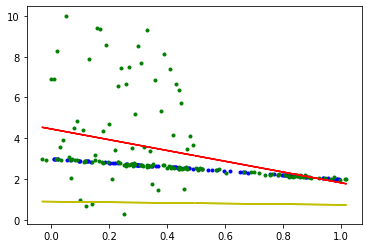

In [14]:
# Step1. 產生測試資料
x_actual = np.random.rand(100)
y_actual = x_actual * (-1) + 3
y_measured = y_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
x_measured = x_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
x_measured = np.append(x_measured, np.array(range(50)) / 100.0)
y_measured = np.append(y_measured, np.zeros(50) + np.random.rand(50) * 10)

# Step2. 
X = np.transpose([x_measured, y_measured])
weights = np.ones(len(X))


fit_func = lambda X: linear_fit_model(linear_ls_errors, [1,1], X[:,0], X[:,1], np.ones(len(X))).x
error_func = lambda X, params: linear_ls_errors(X[:,0],X[:,1],params[0],params[1],np.ones(len(X)))

# Step3. 分別用 LS 與 RANSAC 擬合
sol_lsq = linear_fit_model(linear_ls_errors, [1, 1], x_measured, y_measured,weights)
probs, params, errors = ransac_bayesian(error_func, fit_func,X,
                                 iterations = 100,fit_samples = 10,fit_with_best_n = 100)

plt.plot(x_actual, y_actual, '.b')
plt.plot(x_measured, y_measured, '.g')
plt.plot(x_measured, x_measured * sol_lsq.x[0] + sol_lsq.x[1], 'r')
plt.plot(x_measured, x_measured * params[0] + params[1], 'y')
plt.show()

### Circle

[-0.011607982403371006, 0.025051031134598216, 10.017881381861473]


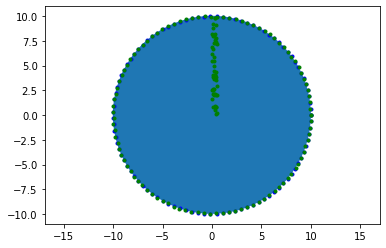

In [30]:
# Step1. 產生測試資料

# 1-1 生成圓形資料點
num_samples = 100
theta = np.linspace(0, 2*np.pi, num_samples)
r = np.random.rand((num_samples))

x_actual = 10 * np.cos(theta)
y_actual = 10 * np.sin(theta)
x_measured = x_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
y_measured = y_actual + np.random.rand(len(x_actual)) * 0.1 - 0.05
x_measured = np.append(x_measured, np.array(range(50)) / 100.0)
y_measured = np.append(y_measured, np.zeros(50) + np.random.rand(50) * 10)

# Step2. 客製化錯誤函式 及 客製化擬合模型
X = np.transpose([x_measured, y_measured])
weights = np.ones(len(X))

## Baysian
# fit_func = lambda X: circle_fit_model([1,1,1], X, np.ones(len(X)))
# error_func = lambda X, params: circle_ls_errors(X[:,0], X[:,1], params[0], params[1], params[2], np.ones(len(X)))
# probs,params,errors = ransac_bayesian(error_func, fit_func,X,
#                                  iterations = 100,fit_samples = 3,fit_with_best_n = 50)

## Classic
fit_func = lambda X: circle_fit_model([1,1,1], X, np.ones(len(X)))
error_func = lambda X, params, threshold: evaluate_func(X[:,0], X[:,1], params[0], params[1], params[2], np.ones(len(X)), threshold)
params = ransac_classic(error_func, fit_func, X, iterations=100, fit_samples=3, inlier_threshold=0.05, min_inliers=10)

fig, ax = plt.subplots()
plt.axis('equal')
plt.plot(x_actual, y_actual, '.b')
plt.plot(x_measured, y_measured, '.g')

print(params)
Circle_1 = plt.Circle((params[0], params[1]), params[2])
ax.add_artist(Circle_1)

plt.show()

## Case 1

In [8]:
os.chdir("/home/mj/HardDisk/ARCS/img/X-Ray/Case_1/Cut")
## Read image
img, gray = read_img("10_mean_0.bmp")
height, width = get_imgInfo(img)

## Image processing
blur = cv2.GaussianBlur(gray,(5,5),0)
dst = cv2.fastNlMeansDenoising(blur,None,10,7,21)

_, threshed = cv2.threshold(dst,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


## Options
# median = median_filter(threshed, 25)
# closed = closing(median, 3)
# opened = opening(closed, 3)
edge = edge_detect(threshed, 0, 20)
ret, labels = cv2.connectedComponents(edge)


#get edge points
edge_points = []
for i in range(height):
    for j in range(width):
        if edge[i,j] == 255:
            edge_points.append([j,i])
            
fit_func = lambda X: circle_fit_model([1,1,1], X, np.ones(len(X)))
error_func = lambda X, params: circle_ls_errors(X[:,0], X[:,1], params[0], params[1], params[2], np.ones(len(X)))
probs,params,errors = ransac_bayesian(error_func, fit_func,np.asarray(edge_points),
                                 iterations = 200,fit_samples = 3,fit_with_best_n = int(0.8*len(edge_points)))

# print(edge_points)
# print(ls_params)
# print(params)

## Show processed images    
# cv2.imshow("Original", img)
cv2.imshow("Gray", gray)
cv2.imshow("Blur", blur)
# cv2.imshow("Non Local Means", dst)
cv2.imshow("Thresh", threshed)
# cv2.imshow("Median", median)
# cv2.imshow("Opening", opened)
# cv2.imshow("Closing", closed)
cv2.imshow("Edge", edge)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
os.chdir("/home/mj/HardDisk/ARCS/img/X-Ray/Case_1/Cut")
try:
    
    images = os.listdir()
    images.sort()
    
    predictions = []
    for image in images:
        img, gray = read_img(image)
        height, width = get_imgInfo(img)
        
        blur = cv2.GaussianBlur(gray,(5,5),0)
        dst = cv2.fastNlMeansDenoising(blur,None,10,7,21)
        _, threshed = cv2.threshold(dst,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#         median = median_filter(threshed, 7)
        edge = edge_detect(threshed, 0, 20)
                    
        # get edge points
        edge_points = []
        for i in range(height):
            for j in range(width):
                if edge[i,j] == 255:
                    edge_points.append([i,j])
        
        fit_sample_numbers = int(0.5*len(edge_points))
        
        fit_func = lambda X: circle_fit_model([1,1,1], X, np.ones(len(X)))
        error_func = lambda X, params: circle_ls_errors(X[:,1], X[:,0], params[0], params[1], params[2], np.ones(len(X)))
        probs,params,errors = ransac_bayesian(error_func, fit_func,np.asarray(edge_points),
                                         iterations = 20,fit_samples = fit_sample_numbers ,fit_with_best_n = int(1*len(edge_points)))

#         fit_func = lambda X: circle_fit_model([1,1,1], X, np.ones(len(X)))
#         error_func = lambda X, params, threshold: evaluate_func(X[:,1], X[:,0], params[0], params[1], params[2], np.ones(len(X)), threshold)
#         params = ransac_classic(error_func, fit_func, np.asarray(edge_points), iterations=1000, fit_samples=fit_sample_numbers, inlier_threshold=5, min_inliers=10)

    

        # Count center
#         cy,cx,r,_ = cf.least_squares_circle((edge_points))
#         predictions.append([cx, cy])
#         print("{}: {}, {}".format(image, cx, cy))
        predictions.append([params[0], params[1]])
        print("{}: {}, {}, {}".format(image ,params[0], params[1], params[2]))

    
except Exception as e:
    print(e)

10_mean_0.bmp: 203.7004419670094, 99.33583859199092, 66.22691687591531
10_mean_1.bmp: 203.68706758481366, 99.21511666213033, 66.34375452949037
10_mean_10.bmp: 203.71163214745067, 98.99189999721078, 66.90900775229727
10_mean_11.bmp: 203.60687400243165, 99.19779941953284, 66.19597923689929
10_mean_12.bmp: 203.56343806993806, 99.17563021397173, 66.76909409171219
10_mean_13.bmp: 203.56288700843297, 99.16322681719528, 66.3517650983494
10_mean_14.bmp: 203.5207474661094, 99.2949204068522, 66.86080739917278
10_mean_15.bmp: 203.476446217289, 99.19312093589858, 66.25150291118784
10_mean_16.bmp: 203.56247352608892, 99.20732742166638, 67.0649604597017
10_mean_17.bmp: 203.71383116635698, 99.32798490481072, 66.4491060295645
10_mean_18.bmp: 203.43640357503742, 99.02920627261011, 66.96888321720787
10_mean_19.bmp: 203.6176105249813, 99.08845860757096, 66.81678020451604
10_mean_2.bmp: 203.41772451236133, 98.94743441718101, 66.3800548764613
10_mean_20.bmp: 203.40479772048715, 99.10463297140367, 66.254801

In [12]:
show_resoult(predictions)

-----------------------------------------------------
Statistics: 
Mean Centroid: (203.61381, 99.17248)
Variance     : (0.01305, 0.01841)
Max Length   : 0.51760, 0.58738 (pixels)


## M-Eestimator

In [45]:
def robust_lsq_m_estimates(error_func, fit_model, X,
                           iterations=1000, priors=None, norm_func=lambda x: 1/(1 + x**0.1)):

    # Step1. 事先機率設定

    # 1-1 如過參數 priors 為 None 時，將其設為全都一樣
    if priors == None:
        prob = np.ones(len(X))
    else:
        prob = priors

    # 1-2 將機率單位化
    prob /= np.sum(prob)
    best_errors = 1e100
    best_param = None
    current_prob = prob.copy()


    # Step2. 計算穩定可靠的權重
    for iter in range(iterations):
        # 2-1 
        params = fit_model(X, prob)
        errors = error_func(X, params, prob)

        #
        if np.sum(errors) < best_errors:
            best_param = params
            best_errors = np.sum(errors)

        #
        current_prob[:] = norm_func(errors[:])
        prob *= current_prob
        prob /= np.sum(prob)


    # Step3.
    params = fit_model(X, prob)
    errors = error_func(X, params, prob)
    if np.sum(errors) < best_errors:
        best_param = params
        
    return prob, best_param, errors